In [1]:
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np

import os

from shutil import copy2

c:\Users\Djcho\anaconda3\envs\MachineLearning\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] No se encontró el proceso especificado'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
in_submission = os.path.exists('/flags/isgrader.flag')
perform_computation = not in_submission 

if in_submission:
    assert os.path.exists('./cifar_net.pth'), 'The trained network for CIFAR was not stored properly. ' + \
                                              'Please read and follow the instructions/important notes.'
    
    assert os.path.exists('./mnist_net.pth'), 'The trained network for MNIST was not stored properly. ' + \
                                              'Please read and follow the instructions/important notes.'
    
    copy2('./cifar_net.pth', './cifar_net_submitted.pth')
    copy2('./mnist_net.pth', './mnist_net_submitted.pth')

# *Assignment Summary

Go through the CIFAR-10 tutorial at https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html, and ensure you can run the code. Modify the architecture that is offered in the CIFAR-10 tutorial to get the best accuracy you can. Anything better than about 93.5% will be comparable with current research. 

Redo the same efforts for the MNIST digit data set.

**Procedural Instructions**:

This assignment is less guided than the previous assignments. You are supposed to train a deep convolutional classifier, and store it in a file. The autograder will load the trained model, and test its accuracy on a hidden test data set. Your classifier's test accuracy will determine your grade for each part according to the following model.

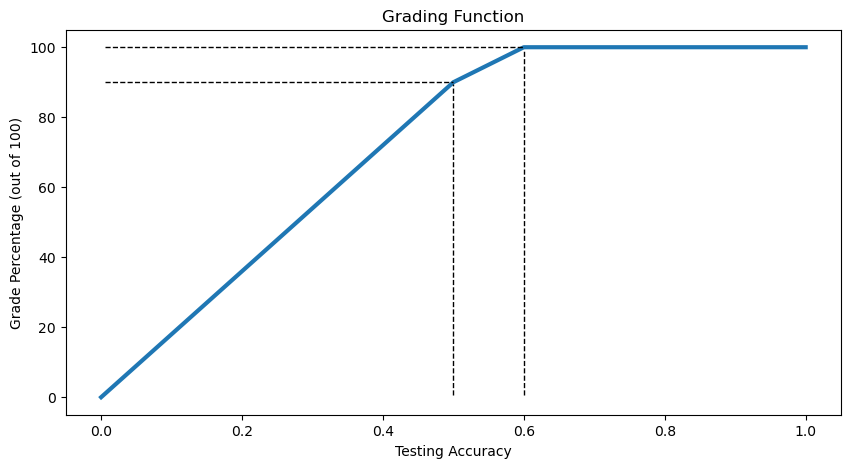

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=100)
ax.plot([0., 0.5, 0.6, 1.], [0., 90., 100., 100.], lw=3)
ax.axhline(y=90, xmin=0.05, xmax=.5, lw=1, ls='--', c='black')
ax.axvline(x=0.5, ymin=0.05, ymax=.86, lw=1, ls='--', c='black')
ax.axhline(y=100, xmin=0.05, xmax=.59, lw=1, ls='--', c='black')
ax.axvline(x=0.6, ymin=0.05, ymax=.95, lw=1, ls='--', c='black')
ax.set_xlabel('Testing Accuracy')
ax.set_ylabel('Grade Percentage (out of 100)')
ax.set_title('Grading Function')
None

# <span style="color:red">Important Notes</span>

You **should** read these notes before starting as these notes include crucial information about what is expected from you.

1. **Use Pytorch**: The autograder will only accept pytorch models.

  * Pytorch's CIFAR-10 tutorial at https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html is the best starting point for this assignment. However, we will not prohibit using or learning from any other tutorial you may find online.


2. **No Downloads**: The running machines are disconnected from the internet. We already have downloaded the pytorch data files, and uploaded them for you. You will need to disable downloading the files if you're using data collector APIs such as `torchvision.datasets`.
  * For the CIFAR data, you should provide the `root='./course-lib/data_cifar', download=False` arguments to the `torchvision.datasets.CIFAR10` API.
  * For the MNIST data, you should provide the `root='./course-lib/data_mnist', download=False` arguments to the `torchvision.datasets.MNIST` API.


3. **Store the Trained Model**: The autograder can not and will not retrain your model. You are supposed to train your model, and then store your best model with the following names:

  * The CIFAR classification model must be stored at `./cifar_net.pth`. 
  * The MNIST classification model must be stored at `./mnist_net.pth`.
  * Place these files under the main directory of your repository and make sure to push them.
  * The trained model may **not exceed 1 MB** in size.


4. **Model Class Naming**: The neural models in the pytorch library are subclasses of the `torch.nn.Module` class. While you can define any architecture as you please, your `torch.nn.Module` must be named `Net` exactly. In other words, you are supposed to have the following lines somewhere in your network definition:

```
import torch.nn as nn
class Net(nn.Module):
   ...
```


5. **Grading Reference Pre-processing**: We will use a specific randomized transformation for grading that can be found in the `Autograding and Final Tests` section. Before training any model for long periods of time, you need to pay attention to the existence of such a testing pre-processing.

6. **Training Rules**: You are able to make the following decisions about your model:

  * You **can** choose and change your architecture as you please. 
      * You can have shallow networks, or deep ones.
      * You can customize the number of neural units in each layer and the depth of the network.
      * You are free to use convolutional, and non-convolutional layers.
      * You can employ batch normalization if you would like to.
      * You can use any type of non-linear layers as you please. `Tanh`, `Sigmoid`, and `ReLU` are some common activation functions.
      * You can use any kind of pooling layers you deem appropriate.
      * etc.
   * You **can** initialize your network using any of the methods described in `https://pytorch.org/docs/stable/nn.init.html`.
      * Some common layer initializations include the Xavier (a.k.a. Glorot), and orthogonal initializations.
      * You may want to avoid initializing your network with all zeros (think about the symmetry of the neural units, and how identical initialization may be a bad idea considering what happens during training).
   * You **can** use and customize any kind of optimization methods you deem appropriate.
      * You can use any first order stochastic methods (i.e., Stochastic Gradient Descent variants) such as Vanilla SGD, Adam, RMSProp, Adagrad, etc.
      * You are also welcome to use second order optimization methods such as newton and quasi-newton methods. However, it may be expensive and difficult to make them work for this setting.
      * Zeroth order methods (i.e., Black Box methods) are also okay (although you may not find them very effective in this setting).
      * You can specify any learning rates first order stochastic methods. In fact, you can even customize your learning rate schedules.
      * You are free to use any mini-batch sizes for stochastic gradient computation.
      * etc.
   * You **can** use any kind of loss function you deem effective.
      * You can add any kind of regularization to your loss.
      * You can pick any kind of classification loss functions such as the cross-entropy and the mean squared loss. 
   * You **cannot** warm-start your network (i.e., you **cannot** use a pre-trained network).
   * You **may** use any kind of image pre-processing and transformations during training. However, for the same transformations to persist at grading time, you may need to apply such transformations within the neural network's `forward` function definition. 
      * In other words, we will drop any `DataLoader` or transformations that your network may rely on to have good performance, and we will only load and use your neural network for grading.

# 1. Object Classification Using the CIFAR Data

## 1.1 Loading the Data

In [4]:
message = 'You can implement the pre-processing transformations, data sets, data loaders, etc. in this cell. \n'
message = message + '**Important Note**: Read the "Grading Reference Pre-processing" bullet above, and look at the'
message = message + ' test pre-processing transformations in the "Autograding and Final Tests" section before'
message = message + ' training models for long periods of time.'
print(message)

# Set device to CUDA if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformation for CIFAR-10
transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize for 3 channels
])

# Transformation for MNIST
transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize for 1 channel
])

# CIFAR-10 datasets
cifar_trainset = torchvision.datasets.CIFAR10(root='./course-lib/data_cifar', train=True,
                                        download=False, transform=transform_cifar)
cifar_trainloader = torch.utils.data.DataLoader(cifar_trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

cifar_testset = torchvision.datasets.CIFAR10(root='./course-lib/data_cifar', train=False,
                                       download=False, transform=transform_cifar)
cifar_testloader = torch.utils.data.DataLoader(cifar_testset, batch_size=4,
                                         shuffle=False, num_workers=2)

# MNIST datasets
mnist_trainset = torchvision.datasets.MNIST(root='./course-lib/data_mnist', train=True,
                                       download=False, transform=transform_mnist)
mnist_trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

mnist_testset = torchvision.datasets.MNIST(root='./course-lib/data_mnist', train=False,
                                      download=False, transform=transform_mnist)
mnist_testloader = torch.utils.data.DataLoader(mnist_testset, batch_size=4,
                                         shuffle=False, num_workers=2)

print("Data loaders have been set up successfully.")

You can implement the pre-processing transformations, data sets, data loaders, etc. in this cell. 
**Important Note**: Read the "Grading Reference Pre-processing" bullet above, and look at the test pre-processing transformations in the "Autograding and Final Tests" section before training models for long periods of time.
Data loaders have been set up successfully.


You can visualize some of the pre-processed images here (This is optional and only for your own reference).
Sample CIFAR-10 images:


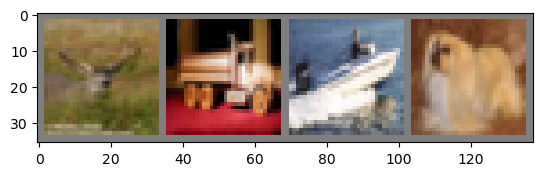

Labels: deer  truck ship  dog  
Sample MNIST images:


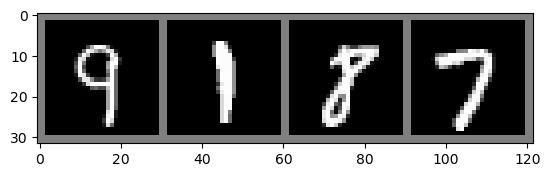

Labels: 9 1 8 7


In [5]:
message = 'You can visualize some of the pre-processed images here (This is optional and only for your own reference).'
print(message)

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(cifar_trainloader)
images, labels = next(dataiter)

# Show images
print('Sample CIFAR-10 images:')
imshow(torchvision.utils.make_grid(images))

# Class labels for CIFAR-10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# Print labels
print('Labels: ' + ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# Repeat for MNIST
dataiter_mnist = iter(mnist_trainloader)
images_mnist, labels_mnist = next(dataiter_mnist)

# Show images
print('Sample MNIST images:')
imshow(torchvision.utils.make_grid(images_mnist))

# Print labels
print('Labels: ' + ' '.join(f'{labels_mnist[j].item():d}' for j in range(4)))

# 1.2 Defining the Model

**Important Note**: As mentioned above, make sure you name the neural module class as `Net`. In other words, you are supposed to have the following lines somewhere in your network definition:

```
import torch.nn as nn
class Net(nn.Module):
   ...
```

In [6]:
message = 'You can define the neural architecture and instantiate it in this cell.'
print(message)

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # CIFAR-10 has 3 input channels
        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        # Define a max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Define a fully connected layer
        self.fc1 = nn.Linear(64 * 8 * 8, 512)  # Adjust the input size
        # Define another fully connected layer
        self.fc2 = nn.Linear(512, 10)  # Output 10 classes

    def forward(self, x):
        # Apply first convolutional layer followed by ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Apply second convolutional layer followed by ReLU and pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the output for the fully connected layer
        x = x.view(-1, 64 * 8 * 8)
        # Apply the first fully connected layer with ReLU
        x = F.relu(self.fc1(x))
        # Apply the second fully connected layer
        x = self.fc2(x)
        return x

# Instantiate the network
net = Net()
print("Neural network architecture defined and instantiated.")

You can define the neural architecture and instantiate it in this cell.
Neural network architecture defined and instantiated.


# 1.3 Initializing the Neural Model

It may be a better idea to fully control the initialization process of the neural weights rather than leaving it to the default procedure chosen by pytorch.

Here is pytorch's documentation about different initialization methods: https://pytorch.org/docs/stable/nn.init.html

Some common layer initializations include the Xavier (a.k.a. Glorot), and orthogonal initializations.

In [7]:
message = 'You can initialize the neural weights here, and not leave it to the library default (this is optional).'
print(message)

import torch.nn.init as init

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define the layers
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        # Iterate over all modules in the network
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                init.xavier_uniform_(module.weight, gain=np.sqrt(2))
                if module.bias is not None:
                    init.constant_(module.bias, 0)
            elif isinstance(module, nn.Linear):
                init.orthogonal_(module.weight)
                init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the network
net = Net()
print("Neural network architecture defined and weights initialized.")

You can initialize the neural weights here, and not leave it to the library default (this is optional).
Neural network architecture defined and weights initialized.


# 1.4 Defining The Loss Function and The Optimizer

In [8]:
message = 'You can define the loss function and the optimizer of interest here.'
print(message)

import torch.optim as optim

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

print("Loss function and optimizer defined.")

You can define the loss function and the optimizer of interest here.
Loss function and optimizer defined.


# 1.5 Training the Model

**Important Note**: In order for the autograder not to time-out due to training during grading, please make sure you wrap your training code within the following conditional statement:

```
if perform_computation:
   # Place any computationally intensive training/optimization code here
    
```

In [9]:
if perform_computation:
    message = 'You can define the training loop and forward-backward propagation here.'
    print(message)
    num_epochs = 5  # Define the number of epochs for training

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(cifar_trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    print('Finished Training')

You can define the training loop and forward-backward propagation here.
Epoch: 1, Batch: 2000, Loss: 1.594
Epoch: 1, Batch: 4000, Loss: 1.297
Epoch: 1, Batch: 6000, Loss: 1.194
Epoch: 1, Batch: 8000, Loss: 1.119
Epoch: 1, Batch: 10000, Loss: 1.067
Epoch: 1, Batch: 12000, Loss: 1.041
Epoch: 2, Batch: 2000, Loss: 0.878
Epoch: 2, Batch: 4000, Loss: 0.873
Epoch: 2, Batch: 6000, Loss: 0.860
Epoch: 2, Batch: 8000, Loss: 0.871
Epoch: 2, Batch: 10000, Loss: 0.852
Epoch: 2, Batch: 12000, Loss: 0.852
Epoch: 3, Batch: 2000, Loss: 0.636
Epoch: 3, Batch: 4000, Loss: 0.651
Epoch: 3, Batch: 6000, Loss: 0.660
Epoch: 3, Batch: 8000, Loss: 0.698
Epoch: 3, Batch: 10000, Loss: 0.661
Epoch: 3, Batch: 12000, Loss: 0.678
Epoch: 4, Batch: 2000, Loss: 0.450
Epoch: 4, Batch: 4000, Loss: 0.486
Epoch: 4, Batch: 6000, Loss: 0.495
Epoch: 4, Batch: 8000, Loss: 0.515
Epoch: 4, Batch: 10000, Loss: 0.510
Epoch: 4, Batch: 12000, Loss: 0.533
Epoch: 5, Batch: 2000, Loss: 0.298
Epoch: 5, Batch: 4000, Loss: 0.345
Epoch: 5, 

# 1.6 Storing the Model

In [10]:
message = 'Here you should store the model at "./cifar_net.pth" .'
print(message)

# Storing the model
torch.save(net.state_dict(), './cifar_net.pth')
print("Model saved at './cifar_net.pth'")

Here you should store the model at "./cifar_net.pth" .
Model saved at './cifar_net.pth'


# 1.7 Evaluating the Trained Model

Here you can visualize a bunch of examples and print the prediction of the trained classifier (this is optional).
Accuracy of the network on the test images: 68 %


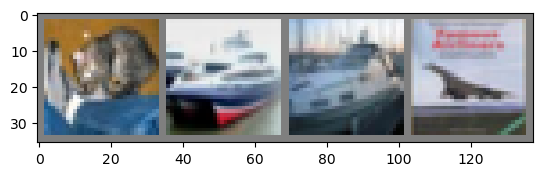

GroundTruth:  cat   ship  ship  plane
Predicted:  cat   ship  ship  plane


In [11]:
message = 'Here you can visualize a bunch of examples and print the prediction of the trained classifier (this is optional).'
print(message)

# Evaluating the trained model
correct = 0
total = 0
with torch.no_grad():  # operations inside don't track history
    for data in cifar_testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

# Optionally visualize some predictions
dataiter = iter(cifar_testloader)
images, labels = next(dataiter)
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

# Show images and predictions
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

In [12]:
message = 'Here you can evaluate the overall accuracy of the trained classifier (this is optional).'
print(message)

# YOUR CODE HERE
raise NotImplementedError()

Here you can evaluate the overall accuracy of the trained classifier (this is optional).


NotImplementedError: 

In [ ]:
message = 'Here you can evaluate the per-class accuracy of the trained classifier (this is optional).'
print(message)

# YOUR CODE HERE
raise NotImplementedError()

## 1.8 Autograding and Final Tests

In [13]:
assert 'Net' in globals().keys(), 'The Net class was not defined earlier. ' + \
                                  'Make sure you read and follow the instructions provided as Important Notes' + \
                                  '(especially, the "Model Class Naming" part).'

cifar_net_path = './cifar_net_submitted.pth' if in_submission else './cifar_net.pth'

assert os.path.exists(cifar_net_path), 'You have not stored the trained model properly. '+  \
                                       'Make sure you read and follow the instructions provided as Important Notes.'

assert os.path.getsize(cifar_net_path) < 1000000, 'The size of your trained model exceeds 1 MB.'



if 'net' in globals():
    del net
net = Net()
net.load_state_dict(torch.load(cifar_net_path))
net = net.eval()

# Disclaimer: Most of the following code was adopted from Pytorch's Documentation and Examples
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

transformation_list = [transforms.RandomAffine(degrees=30, translate=(0.01, 0.01), scale=(0.9, 1.1), 
                                               shear=None, resample=0, fillcolor=0),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

test_pre_tranformation = transforms.Compose(transformation_list)

#cifar_root = '/home/jovyan/work/course-lib/data_cifar' 
cifar_root = './course-lib/data_cifar' 
testset = torchvision.datasets.CIFAR10(root=cifar_root, train=False,
                                       download=False, transform=test_pre_tranformation)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=1)


class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
print('----------')
print(f'Overall Testing Accuracy: {100. * sum(class_correct) / sum(class_total)} %%')

AssertionError: The size of your trained model exceeds 1 MB.

In [ ]:
# "Object Classification Test: Checking the accuracy on the CIFAR Images"


# 2. Digit Recognition Using the MNIST Data

## 2.1 Loading the Data

In [16]:
message = 'You can implement the pre-processing transformations, data sets, data loaders, etc. in this cell. \n'
message = message + '**Important Note**: Read the "Grading Reference Pre-processing" bullet, and look at the'
message = message + ' test pre-processing transformations in the "Autograding and Final Tests" section before'
message = message + ' training models for long periods of time.'
print(message)

# Define transformations
transform_mnist = transforms.Compose([
    transforms.ToTensor(),  # Converts images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images
])

# Load MNIST training data
mnist_trainset = torchvision.datasets.MNIST(root='./course-lib/data_mnist', train=True,
                                            download=False, transform=transform_mnist)
mnist_trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64,
                                                shuffle=True, num_workers=2)

# Load MNIST test data
mnist_testset = torchvision.datasets.MNIST(root='./course-lib/data_mnist', train=False,
                                           download=False, transform=transform_mnist)
mnist_testloader = torch.utils.data.DataLoader(mnist_testset, batch_size=64,
                                               shuffle=False, num_workers=2)

print("MNIST data loaded and preprocessed.")

You can implement the pre-processing transformations, data sets, data loaders, etc. in this cell. 
**Important Note**: Read the "Grading Reference Pre-processing" bullet, and look at the test pre-processing transformations in the "Autograding and Final Tests" section before training models for long periods of time.
MNIST data loaded and preprocessed.


You can visualize some of the pre-processed images here (This is optional and only for your own reference).
Sample MNIST pre-processed images:


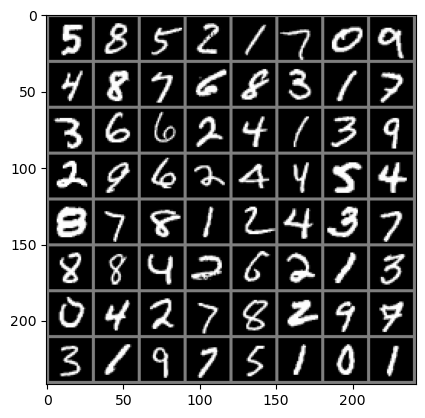

In [17]:
message = 'You can visualize some of the pre-processed images here (This is optional and only for your own reference).'
print(message)

# Function to show an image
def imshow(img):
    img = img * 0.5 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

# Get some random training images
dataiter = iter(mnist_trainloader)
images, labels = next(dataiter)

# Show images
print("Sample MNIST pre-processed images:")
imshow(torchvision.utils.make_grid(images))

# 2.2 Defining the Model

**Important Note**: As mentioned above, make sure you name the neural module class as `Net`. In other words, you are supposed to have the following lines somewhere in your network definition:

```
import torch.nn as nn
class Net(nn.Module):
   ...
```

In [18]:
message = 'You can define the neural architecture and instantiate it in this cell.'
print(message)

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5)  # MNIST images are 1-channel, using 16 filters of size 5x5
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 4 * 4, 120)  # Reduced image size 4x4
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # 10 classes for MNIST digits

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print("Model defined.")

You can define the neural architecture and instantiate it in this cell.
Model defined.


# 2.3 Initializing the Neural Model

It may be a better idea to fully control the initialization process of the neural weights rather than leaving it to the default procedure chosen by pytorch.

Here is pytorch's documentation about different initialization methods: https://pytorch.org/docs/stable/nn.init.html

Some common layer initializations include the Xavier (a.k.a. Glorot), and orthogonal initializations.

In [19]:
message = 'You can initialize the neural weights here, and not leave it to the library default (this is optional).'
print(message)

def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)

net.apply(initialize_weights)
print("Weights initialized.")

You can initialize the neural weights here, and not leave it to the library default (this is optional).
Weights initialized.


# 2.4 Defining The Loss Function and The Optimizer

In [20]:
message = 'You can define the loss function and the optimizer of interest here.'
print(message)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
print("Loss function and optimizer defined.")

You can define the loss function and the optimizer of interest here.
Loss function and optimizer defined.


# 2.5 Training the Model

In [21]:
message = 'You can define the training loop and forward-backward propagation here.'
print(message)
    
if perform_computation:
    for epoch in range(2):  # Loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(mnist_trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = net(inputs)  # Forward pass
            loss = criterion(outputs, labels)
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            running_loss += loss.item()
            if i % 100 == 99:  # Print every 100 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
                running_loss = 0.0

    print('Finished Training')

You can define the training loop and forward-backward propagation here.
[1,   100] loss: 2.238
[1,   200] loss: 1.865
[1,   300] loss: 0.891
[1,   400] loss: 0.448
[1,   500] loss: 0.335
[1,   600] loss: 0.305
[1,   700] loss: 0.242
[1,   800] loss: 0.212
[1,   900] loss: 0.188
[2,   100] loss: 0.171
[2,   200] loss: 0.150
[2,   300] loss: 0.160
[2,   400] loss: 0.152
[2,   500] loss: 0.134
[2,   600] loss: 0.136
[2,   700] loss: 0.128
[2,   800] loss: 0.114
[2,   900] loss: 0.111
Finished Training


# 2.6 Storing the Model

In [22]:
message = 'Here you should store the model at "./mnist_net.pth" .'
print(message)

# Storing the model
torch.save(net.state_dict(), './mnist_net.pth')
print("Model saved at './mnist_net.pth'")

Here you should store the model at "./mnist_net.pth" .
Model saved at './mnist_net.pth'


# 2.7 Evaluating the Trained Model

In [23]:
message = 'Here you can visualize a bunch of examples and print the prediction of the trained classifier (this is optional).'
print(message)

# Test the network on some test data
dataiter = iter(mnist_testloader)
images, labels = next(dataiter)

# Forward pass to get outputs
outputs = net(images)

# Convert outputs to predicted class
_, predicted = torch.max(outputs, 1)

# Display a few images and their predictions
for i in range(4):
    imshow(images[i], predicted[i].item())

Here you can visualize a bunch of examples and print the prediction of the trained classifier (this is optional).


TypeError: imshow() takes 1 positional argument but 2 were given

In [24]:
message = 'Here you can evaluate the overall accuracy of the trained classifier (this is optional).'
print(message)

correct = 0
total = 0
with torch.no_grad():
    for data in mnist_testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Here you can evaluate the overall accuracy of the trained classifier (this is optional).
Accuracy of the network on the test images: 96 %


In [ ]:
message = 'Here you can evaluate the per-class accuracy of the trained classifier (this is optional).'
print(message)

# YOUR CODE HERE
raise NotImplementedError()

## 2.8 Autograding and Final Tests

In [25]:
assert 'Net' in globals().keys(), 'The Net class was not defined earlier. ' + \
                                  'Make sure you read and follow the instructions provided as Important Notes' + \
                                  '(especially, the "Model Class Naming" part).'

mnist_net_path = './mnist_net_submitted.pth' if in_submission else './mnist_net.pth'

assert os.path.exists(mnist_net_path), 'You have not stored the trained model properly. '+  \
                                       'Make sure you read and follow the instructions provided as Important Notes.'

assert os.path.getsize(mnist_net_path) < 1000000, 'The size of your trained model exceeds 1 MB.'

if 'net' in globals():
    del net
net = Net()
net.load_state_dict(torch.load(mnist_net_path))
net = net.eval()

# Disclaimer: Most of the following code was adopted from Pytorch's Documentation and Examples
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

transformation_list = [transforms.RandomAffine(degrees=60, translate=(0.2, 0.2), scale=(0.5, 2.), 
                                               shear=None, resample=0, fillcolor=0),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,), (0.5,))]

test_pre_tranformation = transforms.Compose(transformation_list)

#mnist_root = '/home/jovyan/work/course-lib/data_mnist' 
mnist_root = './course-lib/data_mnist' 
testset = torchvision.datasets.MNIST(root=mnist_root, train=False,
                                     download=False, transform=test_pre_tranformation)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=1)


class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
print('----------')
print(f'Overall Testing Accuracy: {100. * sum(class_correct) / sum(class_total)} %%')

TypeError: RandomAffine.__init__() got an unexpected keyword argument 'resample'

In [ ]:
# "Digit Recognition Test: Checking the accuracy on the MNIST Images"
